In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib # 横軸ラベルの設定など
import seaborn as sns
import datetime
from pykalman import KalmanFilter
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20
color_palette = sns.color_palette("Set1")

# ベータの推定（サンプルデータ）

In [26]:
np.random.seed(1)
n_step_total = 500
alpha, beta_initial_state, beta_covariance = 0.0, 1.0, 0.05
x_mean, x_std = 0.0, 0.1
sigma = 0.2

df_sample = pd.DataFrame(index = np.arange(n_step_total))
df_sample["t"] = np.arange(n_step_total)
df_sample["x"] = np.random.normal(loc = x_mean, scale = x_std, size = n_step_total)
df_sample["alpha"] = alpha
df_sample["beta"] = beta_initial_state + np.random.normal(scale = np.sqrt(beta_covariance), size = n_step_total).cumsum() # ランダムウォーク
df_sample["y"] = df_sample["alpha"] + df_sample["beta"] * df_sample["x"] + np.random.normal(scale = sigma, size = n_step_total)
df_sample["beta_overall"] = df_sample["x"].cov(df_sample["y"]) / df_sample["x"].var()
df_sample["alpha_overall"] = df_sample["y"].mean() - df_sample["x"].mean() * df_sample["beta_overall"]
df_sample["y_pred"] = df_sample["alpha"] + df_sample["beta_overall"] * df_sample["x"]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


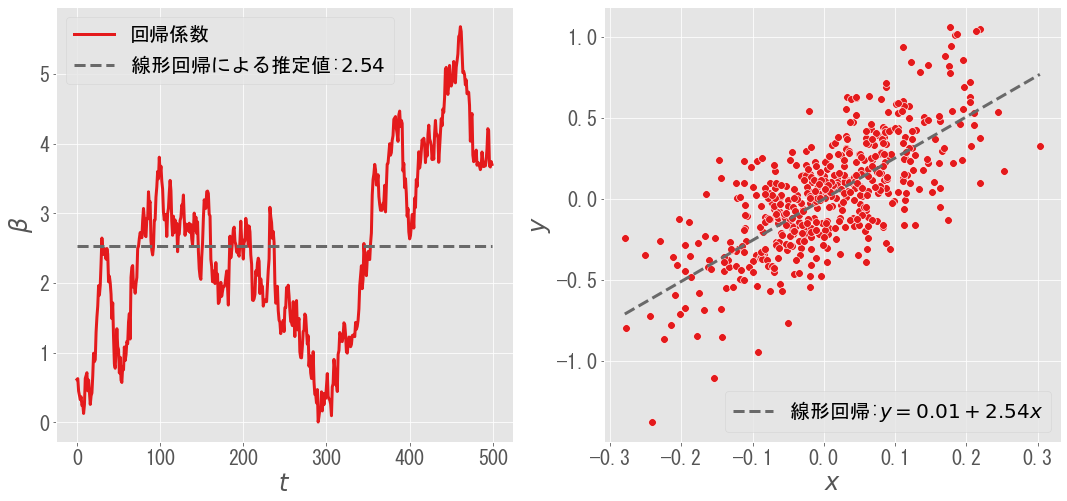

In [27]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("$t$")
ax1.set_ylabel("$\\beta$")
sns.lineplot(data = df_sample, x = "t", y = "beta", label = "回帰係数", lw = 3.0, c = color_palette[0], ax = ax1)
sns.lineplot(data = df_sample, x = "t", y = "beta_overall", label = f"線形回帰による推定値:${df_sample['beta_overall'].iloc[-1]:.2f}$", lw = 3.0, c = "dimgray", ax = ax1, ls = "--")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")
sns.scatterplot(data = df_sample, x = "x", y = "y", ax = ax2, s = 60, c = color_palette[0])
plt.plot([df_sample["x"].min(), df_sample["x"].max()], [df_sample["y_pred"].min(), df_sample["y_pred"].max()], lw = 3.0, c = "dimgray", ls = "--", \
         label = f"線形回帰:$y = {df_sample['alpha_overall'].iloc[-1]:.2f} + {df_sample['beta_overall'].iloc[-1]:.2f}x$")
ax2.legend()

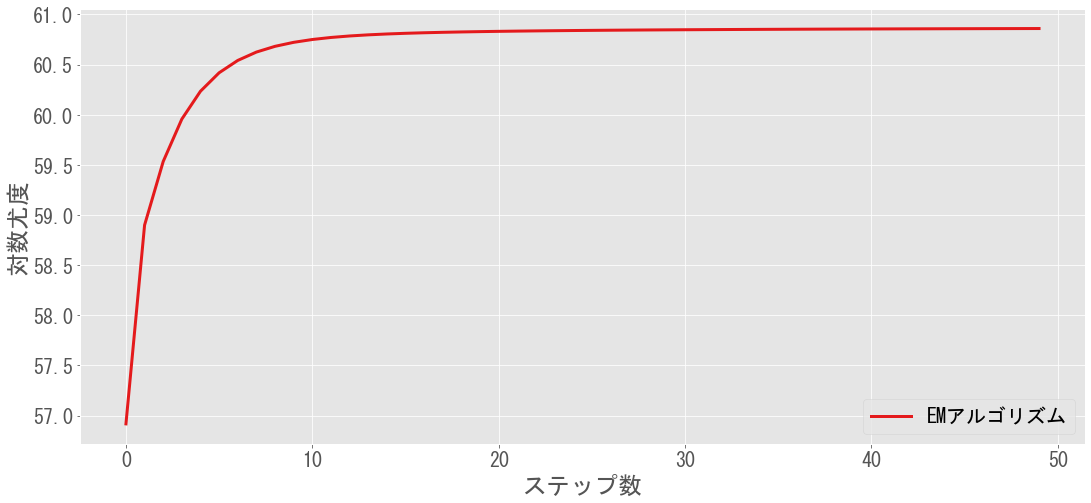

In [28]:
# Initialize Kalman filter parameters
state_mean_initial = 1.0
state_covariance_initial = 0.1
transition_matrix_initial = 1
transition_covariance_initial = beta_covariance
observation_covariance_initial = 0.2 ** 2

# Create Kalman filter
kf = KalmanFilter(
    initial_state_mean = state_mean_initial,
    initial_state_covariance = state_covariance_initial,
    transition_matrices = transition_matrix_initial,
    transition_covariance = transition_covariance_initial,
    transition_offsets = 0,
    observation_matrices = df_sample["x"].values.reshape(-1, 1, 1),
    observation_covariance = observation_covariance_initial,
    observation_offsets = 0,
    em_vars = ["initial_state_mean", "initial_state_covariance", \
               "transition_covariance", "transition_matrices", "transition_offsets", \
               "observation_covariance", "observation_offsets"]
)

# Perform EM algorithm for learning
n_iter = 50
log_likelihoods = np.zeros(n_iter)
for idx in range(n_iter):
    log_likelihoods[idx] = kf.loglikelihood(df_sample["y"].values)
    kf.em(df_sample["y"].values, n_iter = 1)
filtered_state_means, filtered_state_covariances = kf.filter(df_sample["y"].values)
df_sample["beta_mean_kalman_filter"] = filtered_state_means.flatten()
df_sample["beta_std_kalman_filter"] = np.sqrt(filtered_state_covariances.flatten())

fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("ステップ数")
ax1.set_ylabel("対数尤度")
sns.lineplot(x = np.arange(n_iter), y = log_likelihoods, ax = ax1, label = "EMアルゴリズム", c = color_palette[0], lw = 3.0)
ax1.legend()

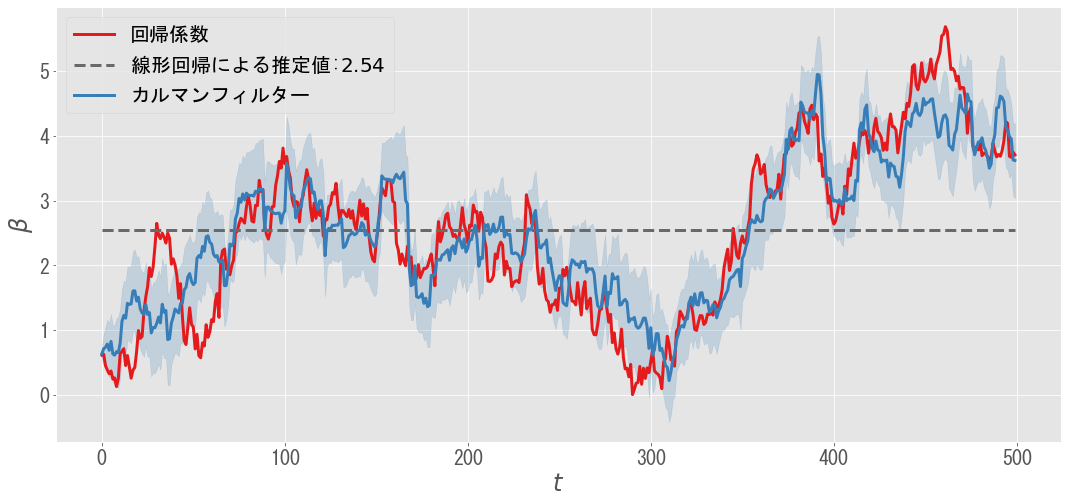

In [29]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("$t$")
ax1.set_ylabel("$\\beta$")
sns.lineplot(data = df_sample, x = "t", y = "beta", label = "回帰係数", lw = 3.0, c = color_palette[0], ax = ax1)
sns.lineplot(data = df_sample, x = "t", y = "beta_overall", label = f"線形回帰による推定値:${df_sample['beta_overall'].iloc[-1]:.2f}$", lw = 3.0, c = "dimgray", ax = ax1, ls = "--")
sns.lineplot(data = df_sample, x = "t", y = "beta_mean_kalman_filter", label = "カルマンフィルター", lw = 3.0, c = color_palette[1])
plt.fill_between(df_sample["t"], df_sample["beta_mean_kalman_filter"] - df_sample["beta_std_kalman_filter"], df_sample["beta_mean_kalman_filter"] + df_sample["beta_std_kalman_filter"], \
                 color = color_palette[1], alpha = 0.2)
ax1.legend()

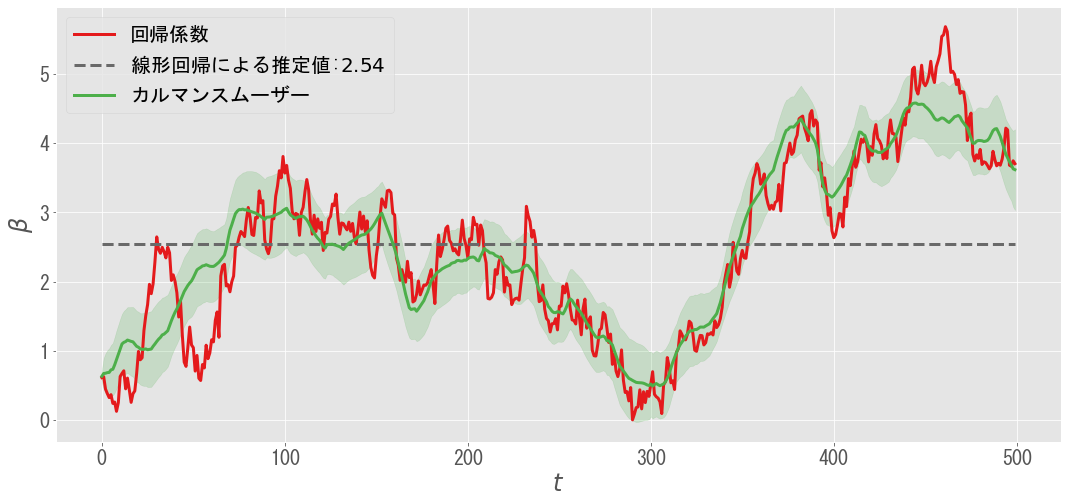

In [30]:
smoothing_state_means, smoothing_state_covariances = kf.smooth(df_sample["y"].values)
df_sample["beta_mean_kalman_smoother"] = smoothing_state_means.flatten()
df_sample["beta_std_kalman_smoother"] = np.sqrt(smoothing_state_covariances.flatten())

fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("$t$")
ax1.set_ylabel("$\\beta$")
sns.lineplot(data = df_sample, x = "t", y = "beta", label = "回帰係数", lw = 3.0, c = color_palette[0], ax = ax1)
sns.lineplot(data = df_sample, x = "t", y = "beta_overall", label = f"線形回帰による推定値:${df_sample['beta_overall'].iloc[-1]:.2f}$", lw = 3.0, c = "dimgray", ax = ax1, ls = "--")
sns.lineplot(data = df_sample, x = "t", y = "beta_mean_kalman_smoother", label = "カルマンスムーザー", lw = 3.0, c = color_palette[2])
plt.fill_between(df_sample["t"], df_sample["beta_mean_kalman_smoother"] - df_sample["beta_std_kalman_smoother"], df_sample["beta_mean_kalman_smoother"] + df_sample["beta_std_kalman_smoother"], \
                 color = color_palette[2], alpha = 0.2)
ax1.legend()

Text(0, 0.5, 'MAE')

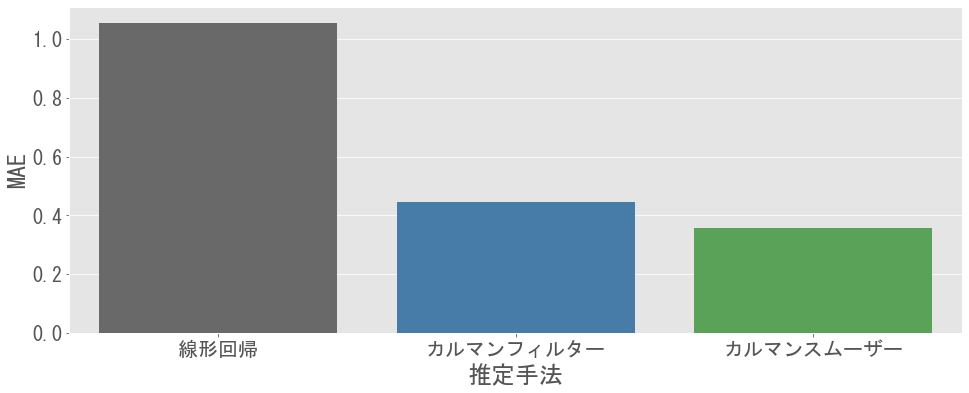

In [31]:
col_beta_estimate = ["beta_overall", "beta_mean_kalman_filter", "beta_mean_kalman_smoother"]
col_beta_estimate_label = ["線形回帰", "カルマンフィルター", "カルマンスムーザー"]
df_error = df_sample[col_beta_estimate] - df_sample["beta"].values.reshape(-1, 1).repeat(len(col_beta_estimate), axis = 1)
df_error = df_error.abs().mean().to_frame().rename(columns = {0: "MAE"})
df_error["LABEL"] = df_error.index
df_error["LABEL"] = df_error["LABEL"].replace(dict(zip(col_beta_estimate, col_beta_estimate_label)))

color_list = ["dimgray", color_palette[1], color_palette[2]]
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 1, 1)
sns.barplot(data = df_error, x = "LABEL", y = "MAE", ax = ax, palette = color_list)
ax.set_xlabel("推定手法")
ax.set_ylabel("MAE")

# 消費性向の分析

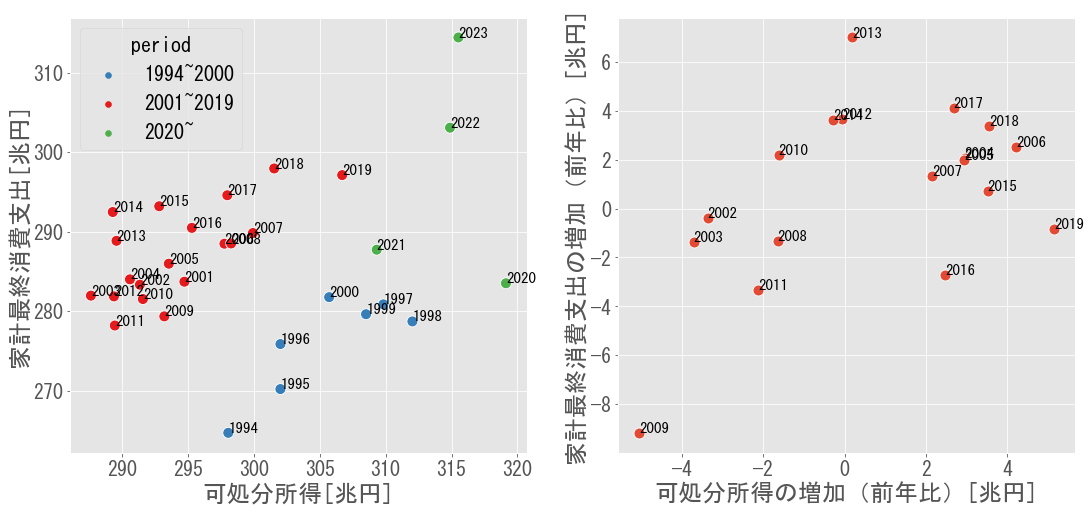

In [32]:
df_kakei = pd.read_excel("./kakei_23q4.xlsx")
df_kakei["fyear"] = df_kakei["fdate"].dt.year
df_kakei["fmonth"] = df_kakei["fdate"].dt.month

# フラグを立てる
df_kakei["flag_year"] = (df_kakei["fmonth"] == 12) # 12月のみに1年の合計値を入れる
df_kakei["income_year"] = np.where(df_kakei["flag_year"], df_kakei.groupby("fyear")["income"].transform("sum"), np.nan)
df_kakei["consumption_year"] = np.where(df_kakei["flag_year"], df_kakei.groupby("fyear")["consumption"].transform("sum"), np.nan)
df_kakei["period"] = np.where(df_kakei["fdate"] >= datetime.datetime(2020, 1, 1), "2020~", \
                              np.where(df_kakei["fdate"] >= datetime.datetime(2001, 1, 1), "2001~2019", \
                              "1994~2000"))
df_kakei["flag_target"] = (df_kakei["period"] == "2001~2019")

# 前年との比較
df_kakei["income_year_diff"] = df_kakei.groupby(["flag_year", "period"])["income_year"].diff()
df_kakei["consumption_year_diff"] = df_kakei.groupby(["flag_year", "period"])["consumption_year"].diff()
df_kakei["income_quarter_diff"] = df_kakei.groupby(["fmonth", "period"])["income"].diff()
df_kakei["consumption_quarter_diff"] = df_kakei.groupby(["fmonth", "period"])["consumption"].diff()
df_target = df_kakei[df_kakei["flag_target"]].dropna(subset = ["income_year_diff", "consumption_year_diff"]).reset_index(drop = True)

# プロット
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("可処分所得[兆円]")
ax1.set_ylabel("家計最終消費支出[兆円]")
sns.scatterplot(data = df_kakei, x = "income_year", y = "consumption_year", s = 120.0, ax = ax1, hue = "period",
                palette = {"1994~2000": color_palette[1], "2001~2019": color_palette[0], "2020~": color_palette[2]})
for _, row in df_kakei.iterrows():
    if row["flag_year"]:
        ax1.text(row["income_year"], row["consumption_year"], row["fyear"], fontsize = 15)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("可処分所得の増加（前年比）[兆円]")
ax2.set_ylabel("家計最終消費支出の増加（前年比）[兆円]")
sns.scatterplot(data = df_target, x = "income_year_diff", y = "consumption_year_diff", s = 120.0, ax = ax2)

for _, row in df_target.iterrows():
    if row["flag_year"]:
        ax2.text(row["income_year_diff"], row["consumption_year_diff"], row["fyear"], fontsize = 15)

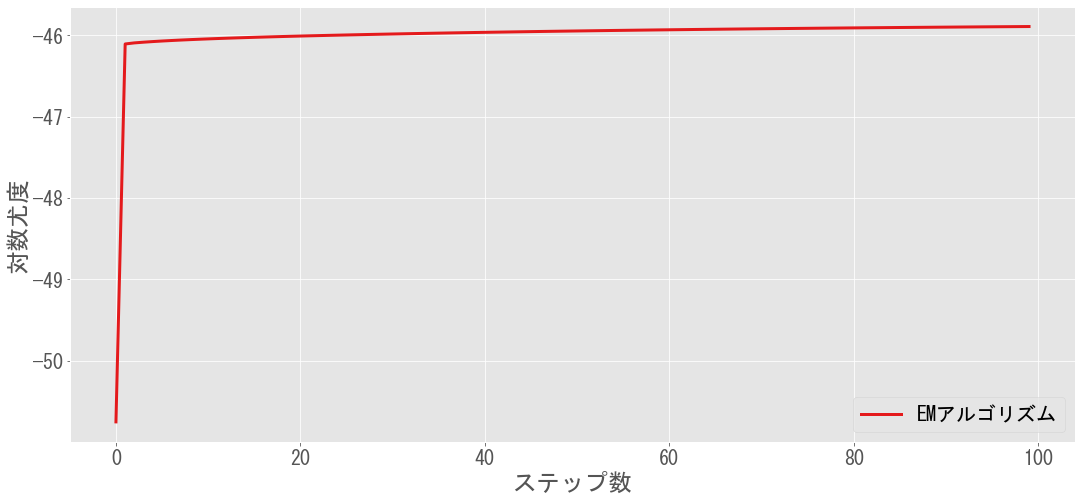

In [33]:
df_target["beta_overall"] = df_target["income_year_diff"].cov(df_target["consumption_year_diff"]) / df_target["income_year_diff"].var()

# Initialize Kalman filter parameters
state_mean_initial = 0.5
state_covariance_initial = 0.1 ** 2.0
transition_matrix_initial = 1
transition_covariance_initial = 0.1 ** 2.0
observation_covariance_initial = 2 ** 2.0

# Create Kalman filter
kf = KalmanFilter(
    initial_state_mean = state_mean_initial,
    initial_state_covariance = state_covariance_initial,
    transition_matrices = transition_matrix_initial,
    transition_covariance = transition_covariance_initial,
    transition_offsets = 0,
    observation_matrices = df_target["income_year_diff"].values.reshape(-1, 1, 1),
    observation_covariance = observation_covariance_initial,
    observation_offsets = 0,
    em_vars = ["initial_state_mean", "initial_state_covariance", \
               "transition_covariance", "observation_covariance", "observation_offsets"
               ]
)

# Perform EM algorithm for learning
n_iter = 100
log_likelihoods = np.zeros(n_iter)
for idx in range(n_iter):
    log_likelihoods[idx] = kf.loglikelihood(df_target["consumption_year_diff"].values)
    kf.em(df_target["consumption_year_diff"].values, n_iter = 1)
filtered_state_means, filtered_state_covariances = kf.filter(df_target["consumption_year_diff"].values)
df_target["beta_mean_kalman_filter"] = filtered_state_means.flatten()
df_target["beta_std_kalman_filter"] = np.sqrt(filtered_state_covariances.flatten())

fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("ステップ数")
ax1.set_ylabel("対数尤度")
sns.lineplot(x = np.arange(n_iter), y = log_likelihoods, ax = ax1, label = "EMアルゴリズム", c = color_palette[0], lw = 3.0)
ax1.legend()

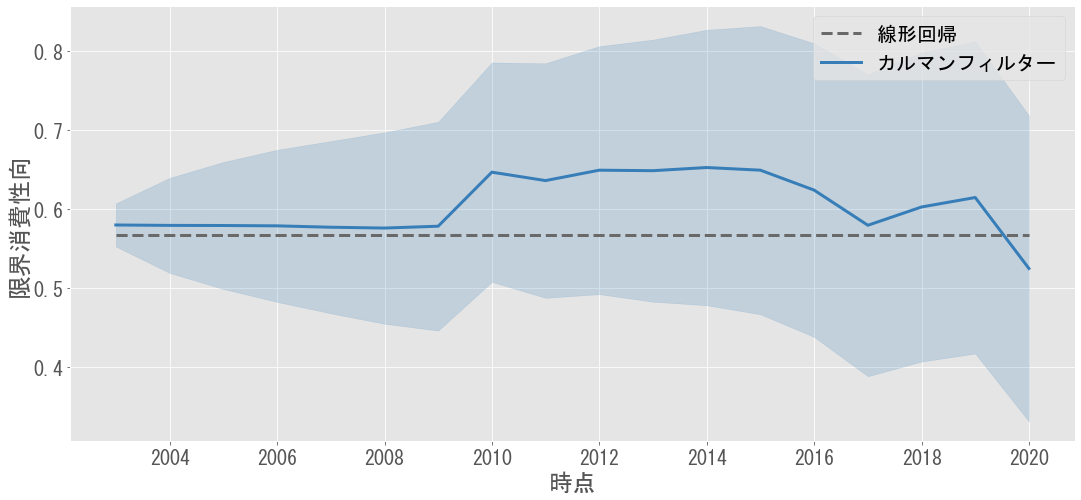

In [34]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("時点")
ax1.set_ylabel("限界消費性向")
sns.lineplot(data = df_target, x = "fdate", y = "beta_overall", label = "線形回帰", lw = 3.0, c = "dimgray", ax = ax1, ls = "--")
sns.lineplot(data = df_target, x = "fdate", y = "beta_mean_kalman_filter", label = "カルマンフィルター", lw = 3.0, c = color_palette[1])
plt.fill_between(df_target["fdate"], df_target["beta_mean_kalman_filter"] - df_target["beta_std_kalman_filter"], df_target["beta_mean_kalman_filter"] + df_target["beta_std_kalman_filter"], \
                 color = color_palette[1], alpha = 0.2)
ax1.legend()

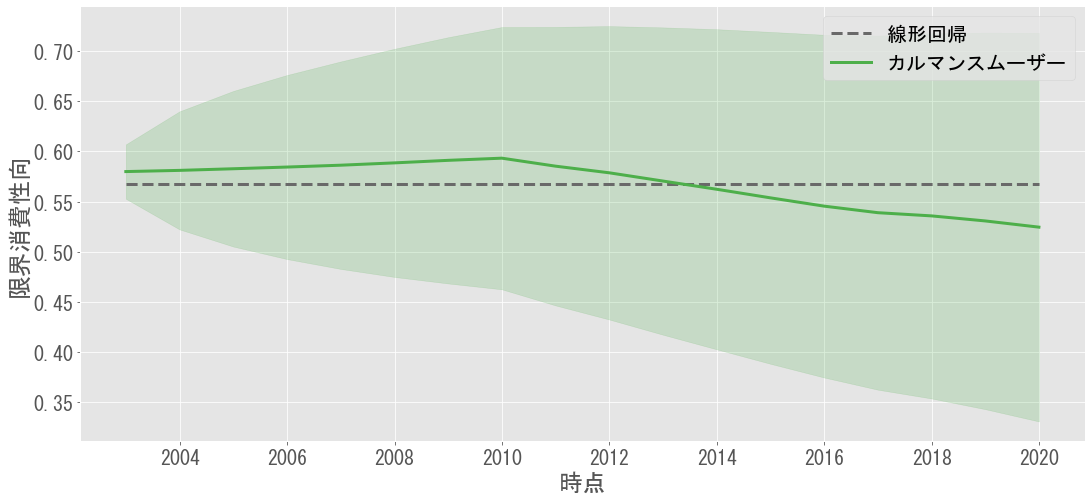

In [35]:
smoothing_state_means, smoothing_state_covariances = kf.smooth(df_target["consumption_year_diff"].values)
df_target["beta_mean_kalman_smoother"] = smoothing_state_means.flatten()
df_target["beta_std_kalman_smoother"] = np.sqrt(smoothing_state_covariances.flatten())

fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("時点")
ax1.set_ylabel("限界消費性向")
sns.lineplot(data = df_target, x = "fdate", y = "beta_overall", label = "線形回帰", lw = 3.0, c = "dimgray", ax = ax1, ls = "--")
sns.lineplot(data = df_target, x = "fdate", y = "beta_mean_kalman_smoother", label = "カルマンスムーザー", lw = 3.0, c = color_palette[2])
plt.fill_between(df_target["fdate"], df_target["beta_mean_kalman_smoother"] - df_target["beta_std_kalman_smoother"], df_target["beta_mean_kalman_smoother"] + df_target["beta_std_kalman_smoother"], \
                 color = color_palette[2], alpha = 0.2)
ax1.legend()

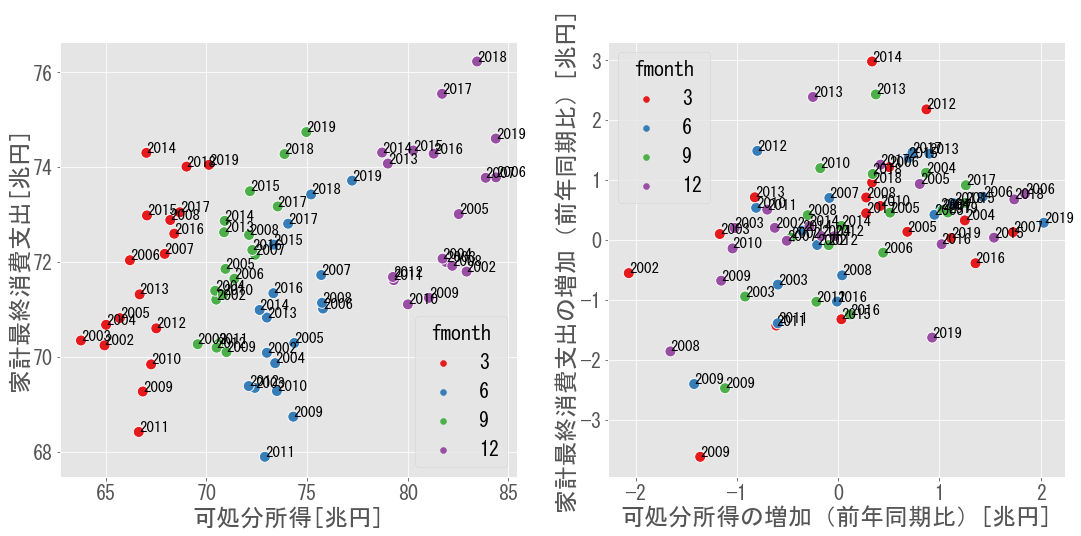

In [36]:
df_target = df_kakei[df_kakei["flag_target"]].dropna(subset = ["income_quarter_diff", "consumption_quarter_diff"]).reset_index(drop = True)

# プロット
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("可処分所得[兆円]")
ax1.set_ylabel("家計最終消費支出[兆円]")
sns.scatterplot(data = df_target, x = "income", y = "consumption", s = 120.0, ax = ax1, palette = color_palette[0:4], hue = "fmonth")
for _, row in df_target.iterrows():
    ax1.text(row["income"], row["consumption"], row["fyear"], fontsize = 15)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("可処分所得の増加（前年同期比）[兆円]")
ax2.set_ylabel("家計最終消費支出の増加（前年同期比）[兆円]")
sns.scatterplot(data = df_target, x = "income_quarter_diff", y = "consumption_quarter_diff", s = 120.0, ax = ax2, palette = color_palette[0:4], hue = "fmonth")

for _, row in df_target.iterrows():
    ax2.text(row["income_quarter_diff"], row["consumption_quarter_diff"], row["fyear"], fontsize = 15)

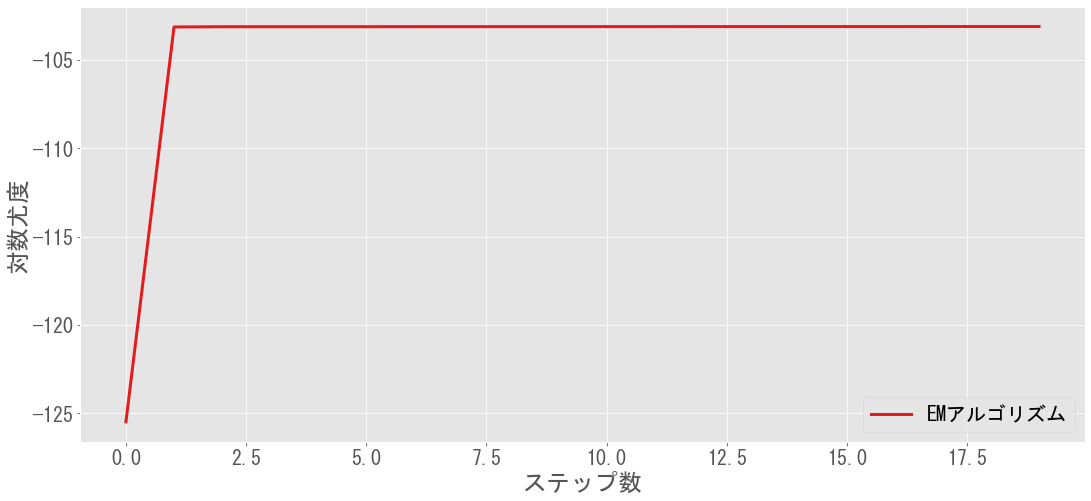

In [37]:
df_target["beta_overall"] = df_target["income_quarter_diff"].cov(df_target["consumption_quarter_diff"]) / df_target["income_quarter_diff"].var()

# Initialize Kalman filter parameters
state_mean_initial = 0.5
state_covariance_initial = 0.02 ** 2.0
transition_matrix_initial = 1
transition_covariance_initial = 0.02 ** 2.0
observation_covariance_initial = 2 ** 2.0

# Create Kalman filter
kf = KalmanFilter(
    initial_state_mean = state_mean_initial,
    initial_state_covariance = state_covariance_initial,
    transition_matrices = transition_matrix_initial,
    transition_covariance = transition_covariance_initial,
    transition_offsets = 0,
    observation_matrices = df_target["income_quarter_diff"].values.reshape(-1, 1, 1),
    observation_covariance = observation_covariance_initial,
    observation_offsets = 0,
    em_vars = ["initial_state_mean", "initial_state_covariance", \
               "transition_covariance", "observation_covariance", "observation_offsets"]
)

# Perform EM algorithm for learning
n_iter = 20
log_likelihoods = np.zeros(n_iter)
for idx in range(n_iter):
    log_likelihoods[idx] = kf.loglikelihood(df_target["consumption_quarter_diff"].values)
    kf.em(df_target["consumption_quarter_diff"].values, n_iter = 1)
filtered_state_means, filtered_state_covariances = kf.filter(df_target["consumption_quarter_diff"].values)
df_target["beta_mean_kalman_filter"] = filtered_state_means.flatten()
df_target["beta_std_kalman_filter"] = np.sqrt(filtered_state_covariances.flatten())

fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("ステップ数")
ax1.set_ylabel("対数尤度")
sns.lineplot(x = np.arange(n_iter), y = log_likelihoods, ax = ax1, label = "EMアルゴリズム", c = color_palette[0], lw = 3.0)
ax1.legend()

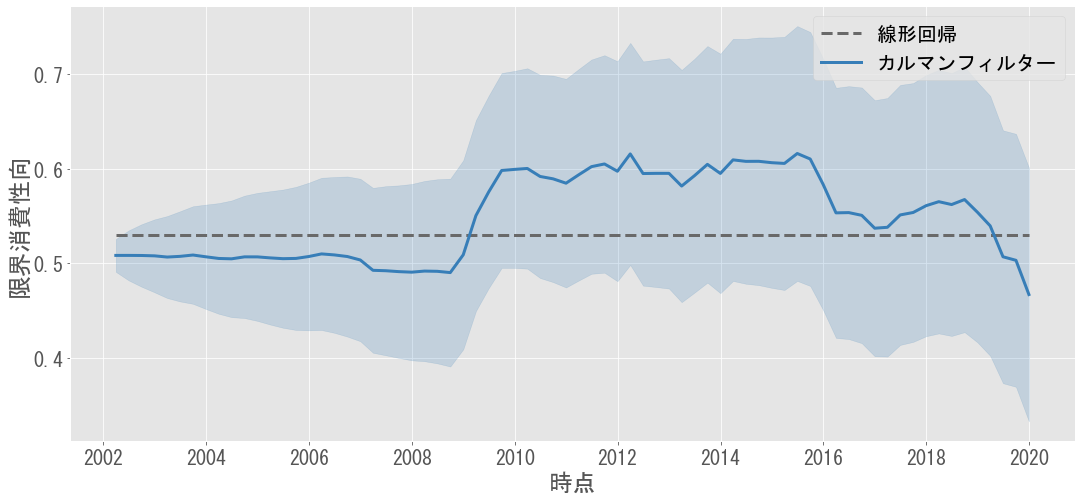

In [38]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("時点")
ax1.set_ylabel("限界消費性向")
sns.lineplot(data = df_target, x = "fdate", y = "beta_overall", label = "線形回帰", lw = 3.0, c = "dimgray", ax = ax1, ls = "--")
sns.lineplot(data = df_target, x = "fdate", y = "beta_mean_kalman_filter", label = "カルマンフィルター", lw = 3.0, c = color_palette[1])
plt.fill_between(df_target["fdate"], df_target["beta_mean_kalman_filter"] - df_target["beta_std_kalman_filter"], df_target["beta_mean_kalman_filter"] + df_target["beta_std_kalman_filter"], \
                 color = color_palette[1], alpha = 0.2)
ax1.legend()

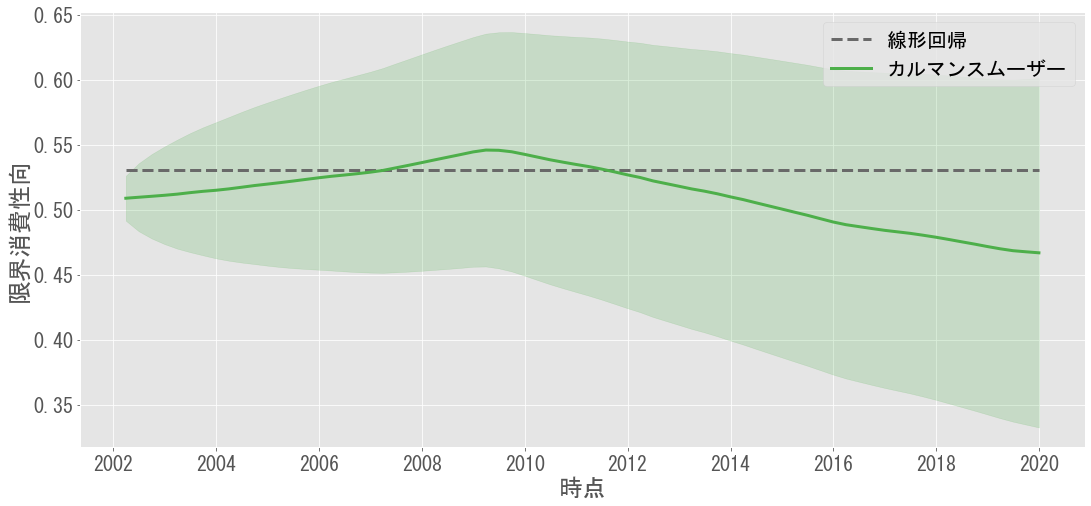

In [39]:
smoothing_state_means, smoothing_state_covariances = kf.smooth(df_target["consumption_quarter_diff"].values)
df_target["beta_mean_kalman_smoother"] = smoothing_state_means.flatten()
df_target["beta_std_kalman_smoother"] = np.sqrt(smoothing_state_covariances.flatten())

fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("時点")
ax1.set_ylabel("限界消費性向")
sns.lineplot(data = df_target, x = "fdate", y = "beta_overall", label = "線形回帰", lw = 3.0, c = "dimgray", ax = ax1, ls = "--")
sns.lineplot(data = df_target, x = "fdate", y = "beta_mean_kalman_smoother", label = "カルマンスムーザー", lw = 3.0, c = color_palette[2])
plt.fill_between(df_target["fdate"], df_target["beta_mean_kalman_smoother"] - df_target["beta_std_kalman_smoother"], df_target["beta_mean_kalman_smoother"] + df_target["beta_std_kalman_smoother"], \
                 color = color_palette[2], alpha = 0.2)
ax1.legend()